# K-Means clustering of charging stations

- clustering of stations on selected location in selected number of clusters based on forecasted utilization
- parts of the algorithm:
1. connecting to the database
    - create a DF with all data + include the info on coordinates
    - expand dataset + TimeSeriesClass + DataLoader
2. loading of the trained model (LSTM)
    - based on github example
3. predictions of consumption and utilization
    - for all stations and selected time range (e.g., 6 months)
4. user selection of location and time frame - manually
5. clustering

In [182]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error

import geopy.distance
import geopandas as gpd

import smopy

import folium

import random

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## 1. Data preprocessing

In [502]:
import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="34.171.207.247",
    database="localai",
    user="postgres",
    password="pglocalai"
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM station_data_hour"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())


   location_id    location_friendlyname location_friendlycode  \
0       107579  Koprivnica Mihanovićeva           HRHEP-48001   
1       107579  Koprivnica Mihanovićeva           HRHEP-48001   
2       107579  Koprivnica Mihanovićeva           HRHEP-48001   
3       107579  Koprivnica Mihanovićeva           HRHEP-48001   
4       107579  Koprivnica Mihanovićeva           HRHEP-48001   

  location_address_cityname  location_address_postnumber  \
0                Koprivnica                        48000   
1                Koprivnica                        48000   
2                Koprivnica                        48000   
3                Koprivnica                        48000   
4                Koprivnica                        48000   

  location_address_streetname location_address_housenumber  \
0     Ulica Antuna Mihanovića                            9   
1     Ulica Antuna Mihanovića                            9   
2     Ulica Antuna Mihanovića                            9   


In [503]:
# dropping the unnecessary columns
df.drop(columns=['location_friendlycode',
                                           'location_address_cityname',
                                          'location_address_postnumber',
                                          'location_address_streetname',
                                          'location_address_housenumber'], axis=1, inplace=True)
df

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
0,107579,Koprivnica Mihanovićeva,Public access - Free access,2019-09-15 12:00:00+00:00,5.000000,7,0,2.477495,21
1,107579,Koprivnica Mihanovićeva,Public access - Free access,2019-09-15 13:00:00+00:00,14.285714,7,1,7.078557,60
2,107579,Koprivnica Mihanovićeva,Public access - Free access,2019-09-15 14:00:00+00:00,13.095238,7,0,6.488678,55
3,107579,Koprivnica Mihanovićeva,Public access - Free access,2019-09-16 07:00:00+00:00,1.428571,7,0,1.778800,6
4,107579,Koprivnica Mihanovićeva,Public access - Free access,2019-09-16 08:00:00+00:00,2.142857,7,0,2.668201,9
...,...,...,...,...,...,...,...,...,...
435210,359766,Rijeka Jolly,Public access - Free access,2022-10-13 13:00:00+00:00,45.833333,2,0,4.453712,55
435211,359766,Rijeka Jolly,Public access - Free access,2022-10-21 11:00:00+00:00,39.166667,2,0,5.640000,47
435212,359766,Rijeka Jolly,Public access - Free access,2022-10-21 12:00:00+00:00,50.000000,2,1,7.200000,60
435213,359766,Rijeka Jolly,Public access - Free access,2022-10-21 13:00:00+00:00,14.166667,2,0,2.040000,17


In [8]:
path = r'...'
geolocation = pd.read_csv(path + r'EV stations location.csv', sep=';', index_col=[0], skiprows=4)
geolocation

# geolocation is a dataframe that has information on coordinates for each station 
# --> this will be used when selecting a radius of location

,Location City,Location Friendly Name,Location Address,Lat,Long,New Location Address (Google Maps or PlugShare or ELEN website),comments
Location Id,,,,,,,
120929,Antunovac,Antunovac,Gospodarska zona bb,45.50985,18.67073,NaN,NaN
141864,Babina Greda,Babina Greda,Ulica Tečine 6,45.10820,18.52379,NaN,NaN
216796,Bakar,KukuljanovoPGŽ,Kukuljanovo bb,45.33132,14.50775,NaN,NaN
229795,Bednja,Bednja,Bednja bb,46.22894,15.98314,Trg svete Marije 27,NaN
168298,Benkovac,Nadin Sjever,Nadin bb,44.06228,15.53117,NaN,NaN
...,...,...,...,...,...,...,...
162002,Zagreb,Lučko Jug,Lučko 82,45.77461,15.87824,NaN,NaN
170046,Zagreb,EurokodTEST,Rudeška cesta 16,45.80411,15.92242,NaN,NaN
215490,Zlatar,Zlatar,Trg Slobode 2,46.09241,16.07706,Zagrebačka ulica bb,NaN


- df -- dataframe from database
- geolocation -- includes info on coordinates

In [9]:
# this is done in the same way as for training of the model

def expand_data(dataframe):
    # function that expands original dataframe with all time stamps
    '''inputs: original dataframe with values for ONE station'''
    
    dataframe_copy = dataframe.copy()
    dataframe_sorted = dataframe_copy.sort_values('location_friendlyname')
    dataframe_sorted['Time'] = pd.to_datetime(dataframe_sorted['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)
    list_names = dataframe_sorted['location_friendlyname'].unique()
    indices_all = []
    dfs = []
    
    for name in list_names:
        dataframe_slice = dataframe_sorted.loc[dataframe_copy['location_friendlyname'] == str(name)].copy().reset_index(drop=True)

        # create new dataframe with index as every hour        
        start_index = dataframe_slice['Time'].min() #starting point is the day of the first index
        end_index = dataframe_slice['Time'].max() # ending pojnt is the day of the last index
        indices = pd.date_range(start_index, end_index, freq='1H')
        indices_all.extend(indices)
        
        dataframe_slice.set_index('Time', inplace=True)
        new_dataframe = pd.DataFrame(index=indices, data=dataframe_slice)

        new_dataframe['Time'] = new_dataframe.index
        new_dataframe['location_id'] = new_dataframe['location_id'].fillna(dataframe_slice['location_id'][0])
        new_dataframe['location_friendlyname'] = new_dataframe['location_friendlyname'].fillna(dataframe_slice['location_friendlyname'][0])
        new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_slice['location_accesstype_title'][0])
        new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan) 
        # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
        
        new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
        new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_slice['connector_count'][0])
        new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
        new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
        new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)
        dfs.append(new_dataframe)
        
    dataframe_total_exp = pd.concat(dfs, ignore_index=True)
    
    return dataframe_total_exp

In [10]:
expanded_data = expand_data(df)
expanded_data

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time
0,120929.0,Antunovac,Public access - Free access,2021-06-30 13:00:00+00:00,0.000000,2.0,0.0,0.000000,0.0,2021-06-30 13:00:00
1,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2021-06-30 14:00:00
2,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2021-06-30 15:00:00
3,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2021-06-30 16:00:00
4,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2021-06-30 17:00:00
...,...,...,...,...,...,...,...,...,...,...
3803007,238019.0,Žminj,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-10-16 17:00:00
3803008,238019.0,Žminj,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-10-16 18:00:00
3803009,238019.0,Žminj,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-10-16 19:00:00
3803010,238019.0,Žminj,Public access - Free access,2022-10-16 20:00:00+00:00,10.000000,2.0,0.0,0.021541,12.0,2022-10-16 20:00:00


### Data preparation for forecasting

In [11]:
data_all = expanded_data.copy()
data_all.head()

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time
0,120929.0,Antunovac,Public access - Free access,2021-06-30 13:00:00+00:00,0.0,2.0,0.0,0.0,0.0,2021-06-30 13:00:00
1,120929.0,Antunovac,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2021-06-30 14:00:00
2,120929.0,Antunovac,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2021-06-30 15:00:00
3,120929.0,Antunovac,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2021-06-30 16:00:00
4,120929.0,Antunovac,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2021-06-30 17:00:00


In [12]:
# here selected time range of data for each station is selected as mock-up data for forecasting 
# with this we ensure that each station has equal data to be predicted

real_data_pom = []

# variables time_start and time_end are manually selected just to create a prediction set
time_start = '2023-08-01'
time_end = '2024-11-01'

for name in list(data_all['location_friendlyname'].unique()):
    filtered_pom = data_all.loc[data_all['location_friendlyname'] == str(name)].reset_index(drop=True)
    filtered_pom['Time'] = pd.to_datetime(filtered_pom['Time'])
    df_pom = filtered_pom.copy()
    # print(df_pom['Time'].max())
    df_pom['Time'] = filtered_pom['Time'] + pd.Timedelta(days=730) 
    # in the above line we create a mockup dataset for 2024. considering measurements of the two years before
    # print(df_pom['Time'].max())
    # here we slice part of dataframe for each station depending on the time_start and time_end
    df_pom = df_pom[(df_pom['Time'] > time_start) & (df_pom['Time'] < time_end)].reset_index(drop=True)
    
    # print(df_pom)
    
    if len(df_pom) == 0:
        print('There is no data for station {}.'.format(str(name)))
    real_data_pom.append(df_pom)
    
real_data = pd.concat(real_data_pom, ignore_index = True)

There is no data for station Sveti Martin na Muri.
There is no data for station eRoaming Showcase Ebee.


In [13]:
real_data.loc[real_data['location_id']==120929]

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time
0,120929.0,Antunovac,Public access - Free access,2021-08-01 01:00:00+00:00,50.000000,2.0,1.0,1.754864,60.0,2023-08-01 01:00:00
1,120929.0,Antunovac,Public access - Free access,2021-08-01 02:00:00+00:00,50.000000,2.0,1.0,1.754864,60.0,2023-08-01 02:00:00
2,120929.0,Antunovac,Public access - Free access,2021-08-01 03:00:00+00:00,50.000000,2.0,1.0,1.754864,60.0,2023-08-01 03:00:00
3,120929.0,Antunovac,Public access - Free access,2021-08-01 04:00:00+00:00,50.000000,2.0,1.0,1.754864,60.0,2023-08-01 04:00:00
4,120929.0,Antunovac,Public access - Free access,2021-08-01 05:00:00+00:00,39.166667,2.0,0.0,1.374643,47.0,2023-08-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...
10953,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2024-10-30 10:00:00
10954,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2024-10-30 11:00:00
10955,120929.0,Antunovac,Public access - Free access,2022-10-31 12:00:00+00:00,39.166667,2.0,0.0,2.185596,47.0,2024-10-30 12:00:00
10956,120929.0,Antunovac,Public access - Free access,2022-10-31 13:00:00+00:00,50.000000,2.0,1.0,2.790123,60.0,2024-10-30 13:00:00


- real_data -- DF that represents future dataset of data, it will be used for forecasting

In [14]:
# total_id_locations will be used for TimeSeries class
total_id_locations = list(expanded_data['location_id'].unique())
len(total_id_locations)

257

In [15]:
# here dataset is transformed - new features are added and unnecessary features are removed
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, all_loc_id):
        
        # Extract year, month, and day from the timestamp
        dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
        dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
        dataframe['Day'] = pd.DatetimeIndex(dataframe['Time']).dayofweek
        
        # Convert year to the number of years since 1970
        dataframe['Year'] = dataframe['Year'] - 1970
                
        # One-hot encode the month
        dataframe = pd.get_dummies(dataframe, columns=['Month'])
        
        num_months = (dataframe.filter(regex='Month_')).shape[-1]
        
        # if there are less than 12 months in dataset (for example, if training dataset consists of only 9 months)
        # this if condition adds columns for all the months - in case there are missing months, these columns are filled with zeros
        if num_months < 12:
            list_existing_months = dataframe.filter(regex='Month_').columns
            list_all_months = [f'Month_{i}' for i in range(1, 13)]
            list_non_existing_months = [x for x in list_all_months if x not in list_existing_months]
            for i in list_non_existing_months:
                dataframe[i] = 0
            
        # print(dataframe)
        
        # Transform day of the week into the corresponding weekday
        weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dataframe['Day'] = dataframe['Day'].apply(lambda x: weekdays[x])
        
        # One-hot encode the day
        dataframe = pd.get_dummies(dataframe, columns=['Day'])
        num_days = (dataframe.filter(regex='Day_')).shape[-1]
        if num_days < 7:
            list_existing_days = dataframe.filter(regex='Day_').columns
            list_all_days = [f'Day_{i}' for i in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
            list_non_existing_days = [x for x in list_all_days if x not in list_existing_days]
            for i in list_non_existing_days:
                dataframe[i] = 0
        
        # location encoding
        dataframe = pd.get_dummies(dataframe, columns=['location_id'])
        
        num_loc = (dataframe.filter(regex='location_id_')).shape[-1] # extracting the total number of locations
        
        # this condition checks if there are same numbers of locations in each set (train, validation etc)
        if num_loc < len(all_loc_id):
            list_existing_loc = dataframe.filter(regex='location_id_').columns # list of current locations
            list_all_loc = [f'location_id_{i}' for i in all_loc_id]
            list_non_existing_loc = [x for x in list_all_loc if x not in list_existing_loc]
            for i in list_non_existing_loc:
                dataframe[i] = 0
        
        # Convert 'public access' to 1 and 'private access' to 0
        #dataframe.iloc[:, 0] = (dataframe.iloc[:, 0] == 'Public access - Free access').astype('float32')
        dataframe.drop(columns=['charging_hour', 'location_friendlyname', 'location_accesstype_title', 'Time'], axis=1, inplace=True)

        # Convert the label column to a tensor - labels have 2 features (energy consumption and utilization)
        labels = torch.tensor(dataframe[['energy_consumption', 'utilization']].values, dtype=torch.float32)
        
        # Convert the features columns to tensors - features are all the other columns
        features = torch.tensor(dataframe[dataframe.columns.difference(['energy_consumption', 'utilization'])].values, dtype=torch.float32)
        
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [16]:
real_data_filtered = TimeSeriesDataset(real_data, total_id_locations)

In [17]:
real_data_filtered.features.shape

torch.Size([2591673, 280])

In [18]:
real_data_filtered.labels.shape

torch.Size([2591673, 2])

### Data loaders

In [19]:
real_data_loader = DataLoader(real_data_filtered, batch_size = 1024, shuffle = False)

## 2. Loading of trained model 

In [20]:
# I was using this part of the code - better results
class LSTM_TimeSeries(nn.Module): # Should always inherit from nn.Module parent class
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super().__init__() # class super constructor
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layer_size, batch_first=True) # lstm consisting of 3 layers
        self.linear = nn.Linear(hidden_size, output_size) # final linear layer on top
        
    def forward(self, x): # forward pass in the neural network
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [21]:
# Function to calculate the mean squared error
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true.detach().numpy(), y_pred.detach().numpy())

In [22]:
# the next arguments are defined while training the model
input_size = real_data_filtered.features.size(1)
hidden_size = 64
layer_size = 2
output_size = 2

model_lstm = LSTM_TimeSeries(input_size, hidden_size, layer_size, output_size)
model_lstm.load_state_dict(torch.load('lstm_best_model_all_stations_weights_pickle_final_version.pickle'))

# the pickle file is the file of the model trained on all stations

# if the loading of pre-trained model was successful, the output should be "All keys matched successfully."

<All keys matched successfully>

In [23]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model_lstm.parameters(), lr=0.001)

In [24]:
model_lstm

LSTM_TimeSeries(
  (lstm): LSTM(280, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)

## 3. Predictions 

In [25]:
pred_consumption_test = pd.DataFrame()
pred_utilization_test = pd.DataFrame()
real_consumption_test = pd.DataFrame()
real_utilization_test = pd.DataFrame()

In [26]:
# prediction part on the selected set
pred_consumption = []
pred_utilization = []
real_consumption = []
real_utilization = []

test_loss = 0.0
test_mse = 0.0

for inputs, labels in real_data_loader:
    outputs_test = model_lstm(inputs)
    loss = criterion(outputs_test.squeeze(), labels)
    # print('Outputs shape: ', outputs.squeeze().shape)
    pred_consumption += outputs_test.squeeze().detach().numpy()[:, 0].tolist()
    pred_utilization += outputs_test.squeeze().detach().numpy()[:, 1].tolist()
    real_consumption += labels.numpy()[:, 0].tolist()
    real_utilization += labels.numpy()[:, 1].tolist()
    test_loss += loss.item() * inputs.size(0)
    test_mse += calculate_mse(labels, outputs_test)

pred_consumption_test['Final'] = pred_consumption
pred_utilization_test['Final'] = pred_utilization
real_consumption_test['Final'] = real_consumption
real_utilization_test['Final'] = real_utilization


In [27]:
pred_consumption_test

,Final
0,0.657079
1,1.218370
2,1.273281
3,1.196695
4,1.321840
...,...
2591668,-0.002704
2591669,-0.002711
2591670,-0.002716
2591671,2.076033


In [28]:
pred_utilization_test

,Final
0,48.238441
1,48.673431
2,49.702698
3,49.893421
4,40.538227
...,...
2591668,-0.002117
2591669,-0.002109
2591670,-0.002101
2591671,9.538948


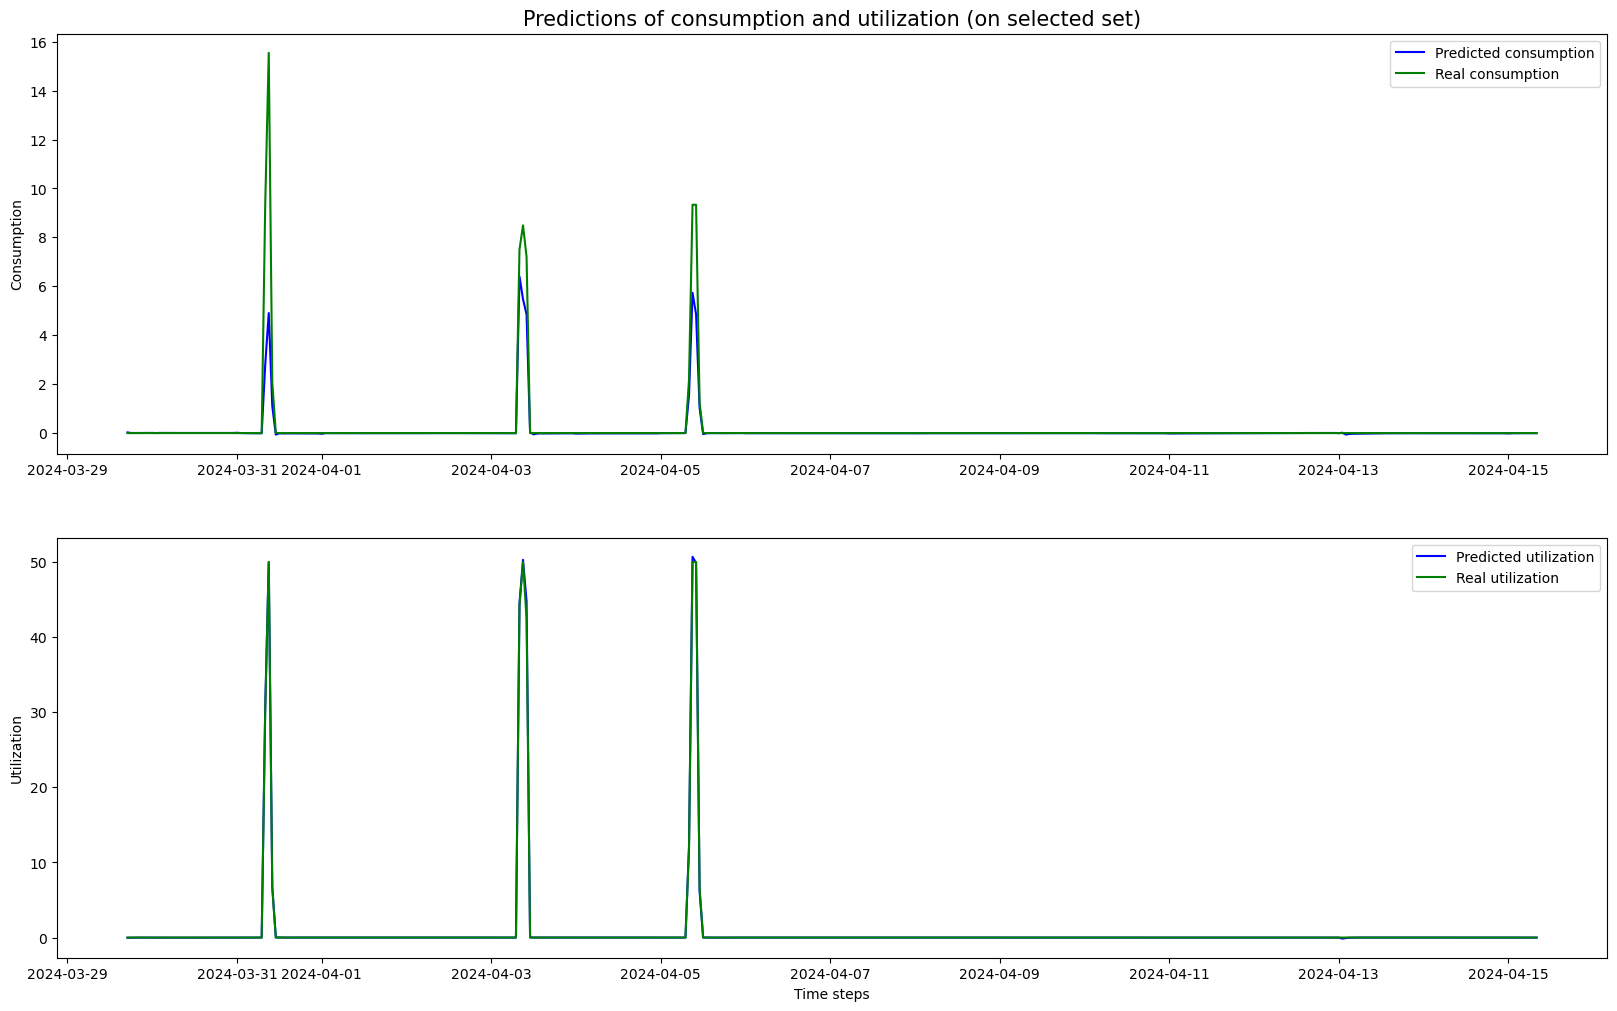

In [29]:
# plot the forecasted results

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

ax1.plot(real_data['Time'].iloc[5800:6200], pred_consumption_test['Final'].iloc[5800:6200], color='b', label='Predicted consumption')
ax1.plot(real_data['Time'].iloc[5800:6200], real_consumption_test['Final'].iloc[5800:6200], color='g', label='Real consumption')
ax1.set(ylabel='Consumption')
ax1.legend()
ax1.set_title('Predictions of consumption and utilization (on selected set)', fontsize=15)
    
ax2.plot(real_data['Time'].iloc[5800:6200], pred_utilization_test['Final'].iloc[5800:6200], color='b', label='Predicted utilization')
ax2.plot(real_data['Time'].iloc[5800:6200], real_utilization_test['Final'].iloc[5800:6200], color='g', label='Real utilization')
ax2.set(xlabel = 'Time steps', ylabel = 'Utilization')
ax2.legend()

plt.show()

In [30]:
pred_utilization_test['location_id'] = real_data['location_id'].copy()
pred_utilization_test['location_friendlyname'] = real_data['location_friendlyname'].copy()
pred_utilization_test['Time'] = real_data['Time'].copy()
pred_utilization_test.rename(columns = {'Final': 'Predicted utilization'}, inplace = True)

In [31]:
pred_utilization_test

,Predicted utilization,location_id,location_friendlyname,Time
0,48.238441,120929.0,Antunovac,2023-08-01 01:00:00
1,48.673431,120929.0,Antunovac,2023-08-01 02:00:00
2,49.702698,120929.0,Antunovac,2023-08-01 03:00:00
3,49.893421,120929.0,Antunovac,2023-08-01 04:00:00
4,40.538227,120929.0,Antunovac,2023-08-01 05:00:00
...,...,...,...,...
2591668,-0.002117,238019.0,Žminj,2024-10-15 17:00:00
2591669,-0.002109,238019.0,Žminj,2024-10-15 18:00:00
2591670,-0.002101,238019.0,Žminj,2024-10-15 19:00:00
2591671,9.538948,238019.0,Žminj,2024-10-15 20:00:00


## 4. Manual selection of time range and location

In [528]:
# this time_start and time_end variables are different than the ones before -- these variables are for clustering

time_start = '2024-07-01'
time_end = '2024-08-31'
lat_init = 45.8
long_init = 15.97
radius = 10 # in kilometres


In [529]:
geolocation

,Location City,Location Friendly Name,Location Address,Lat,Long,New Location Address (Google Maps or PlugShare or ELEN website),comments
Location Id,,,,,,,
120929,Antunovac,Antunovac,Gospodarska zona bb,45.50985,18.67073,NaN,NaN
141864,Babina Greda,Babina Greda,Ulica Tečine 6,45.10820,18.52379,NaN,NaN
216796,Bakar,KukuljanovoPGŽ,Kukuljanovo bb,45.33132,14.50775,NaN,NaN
229795,Bednja,Bednja,Bednja bb,46.22894,15.98314,Trg svete Marije 27,NaN
168298,Benkovac,Nadin Sjever,Nadin bb,44.06228,15.53117,NaN,NaN
...,...,...,...,...,...,...,...
162002,Zagreb,Lučko Jug,Lučko 82,45.77461,15.87824,NaN,NaN
170046,Zagreb,EurokodTEST,Rudeška cesta 16,45.80411,15.92242,NaN,NaN
215490,Zlatar,Zlatar,Trg Slobode 2,46.09241,16.07706,Zagrebačka ulica bb,NaN


In [530]:
def find_in_radius(geoloc, init_lat, init_long, init_radius):
    '''inputs: dataframe with coordinates for each station, latitude and longitude of starting point, selected radius'''
    # the function that selects charging stations that are inside a radius and returns a list of IDs
    
    coords_init = (init_lat, init_long)
    ids_station = []
    
    # in this for loop we go through coordinates for each station, calculate distances and check if the chosen station is inside radius
    for i in range(len(geoloc)):
        geo_pom = geoloc.iloc[i:i+1, :]
        # print('Station: ', geo_pom['Location City'].values[0])
        coords_station = (geo_pom['Lat'].values[0], geo_pom['Long'].values[0])
        if math.isnan(geo_pom['Lat'].values[0]) or math.isnan(geo_pom['Long'].values[0]):
            print('The station ', geo_pom['Location City'].values[0], ' does not have proper coordinates.')
            continue
        
        # distance_km is distance between selected point (init_lat, init_long) and station in kilometers
        distance_km = geopy.distance.geodesic(coords_init, coords_station).km
        
        # if selected station is inside the circle
        if distance_km < init_radius:
            # print(geo_pom.index.values[0], geo_pom['Location Friendly Name'].values[0])
            ids_station.append(geo_pom.index.values[0])
    # print(ids_station)
    
    '''output: list of chosen IDs'''
    return ids_station
    
    
    

In [531]:
ids_in_radius = find_in_radius(geolocation, lat_init, long_init, radius)
len(ids_in_radius)

The station  Berlin  does not have proper coordinates.
The station  Ivanje  does not have proper coordinates.
The station  Sveti Martin na Muri  does not have proper coordinates.
The station  Zagreb  does not have proper coordinates.


19

In [532]:
# example of list of IDs
ids_in_radius

[180433,
 180432,
 230087,
 180431,
 230084,
 173895,
 129443,
 230083,
 230082,
 230085,
 230086,
 154558,
 163591,
 154564,
 231041,
 140631,
 162001,
 162002,
 170046]

In [533]:
# function that creates a new dataframe with predicted utilization only for selected time range and stations in certain radius
def create_new_df(pred_utilization, list_ids, time_s, time_e):
    '''inputs: dataframe with predicted utilization, list of ids in selected radius, start and end time index'''
    
    indices = pd.date_range(time_s, time_e, freq='1H')
    df_stations = pd.DataFrame(index=indices)

    
    for name in list_ids:
        pom_df = pred_utilization.loc[pred_utilization['location_id'] == name].set_index('Time', drop=True)
        if pom_df['Predicted utilization'].isna().sum() == len(pom_df):
            print('Station {} does not have measurements to group.'.format(str(name)))
        elif time_s not in pom_df.index:
            print('There are no measurements for selected time frame and station ', name)
        else:
            df_stations[name] = pom_df[['Predicted utilization']]
    
    '''output: dataframe where index = [time_s, time_e] and columns = list_ids'''
    return df_stations

In [534]:
selected_stations = create_new_df(pred_utilization_test, ids_in_radius, time_start, time_end)
selected_stations

There are no measurements for selected time frame and station  170046


,180433,180432,230087,180431,230084,173895,129443,230083,230082,230085,230086,154558,163591,154564,231041,140631,162001,162002
2024-07-01 00:00:00,0.001646,0.004558,-0.037369,-0.008502,49.903561,0.013441,0.011330,-0.023690,-0.006792,-0.014228,-0.038927,-0.006163,-0.006739,0.014212,0.001583,0.014557,0.015023,0.002342
2024-07-01 01:00:00,-0.001251,0.002591,-0.038153,-0.010221,49.926533,0.015207,0.004989,-0.017799,0.002367,-0.012709,-0.014096,0.022389,-0.027381,0.011083,-0.001536,0.013131,0.012481,0.005766
2024-07-01 02:00:00,-0.001178,-0.002357,-0.044554,-0.010646,50.061237,0.015112,-0.001001,-0.019416,0.017724,-0.012545,-0.019865,0.034257,-0.024249,0.007210,-0.002996,0.006496,0.009075,0.005912
2024-07-01 03:00:00,-0.001820,-0.002460,-0.043391,-0.009873,50.121849,0.011736,-0.001228,-0.020296,-0.087290,-0.013429,-0.027453,0.023682,-0.025979,0.005489,-0.003391,0.004777,0.003581,0.004845
2024-07-01 04:00:00,-0.001714,-0.002024,-0.044394,-0.009805,40.556461,0.013781,-0.001932,-0.020484,-0.043661,-0.013941,-0.023564,0.028297,-0.023684,0.004087,-0.003806,0.001849,0.004676,6.410806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30 20:00:00,0.002872,-0.002945,-0.026537,-0.001005,-0.008004,-0.004879,-0.003152,50.434105,33.847591,0.001324,50.099918,2.290171,9.058158,-0.000451,-0.011291,0.007878,0.001395,-0.008513
2024-08-30 21:00:00,0.003312,-0.002897,-0.024219,-0.000985,-0.007995,-0.007771,-0.003155,50.529125,50.347408,0.001454,49.990658,9.283546,30.288572,-0.003902,-0.002509,0.007482,0.001191,3.008567
2024-08-30 22:00:00,0.002950,-0.002812,-0.020635,-0.000964,-0.007985,-0.006281,-0.003153,12.675566,50.373814,0.001536,3.922932,2.631776,0.309092,-0.003286,-0.007437,0.006525,0.000996,2.744452
2024-08-30 23:00:00,0.002831,-0.002698,-0.019069,-0.000942,-0.007982,-0.004985,-0.003147,-0.025702,4.344916,0.001584,-0.002802,-0.025176,-0.017512,-0.000834,-0.002836,0.005218,0.000811,0.006307


In [535]:
pred_utilization_test

,Predicted utilization,location_id,location_friendlyname,Time
0,48.238441,120929.0,Antunovac,2023-08-01 01:00:00
1,48.673431,120929.0,Antunovac,2023-08-01 02:00:00
2,49.702698,120929.0,Antunovac,2023-08-01 03:00:00
3,49.893421,120929.0,Antunovac,2023-08-01 04:00:00
4,40.538227,120929.0,Antunovac,2023-08-01 05:00:00
...,...,...,...,...
2591668,-0.002117,238019.0,Žminj,2024-10-15 17:00:00
2591669,-0.002109,238019.0,Žminj,2024-10-15 18:00:00
2591670,-0.002101,238019.0,Žminj,2024-10-15 19:00:00
2591671,9.538948,238019.0,Žminj,2024-10-15 20:00:00


## 5. Clustering

In [536]:
class K_Means:
    
    # initialization of parameters
    def __init__(self, k, tol, max_iter):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        # self.inertia_ = 0

    # fitting of the parameters
    def fit(self,data):    
        self.centroids = {}
        
        # we want the model to cluster based on busy hour values, so we ignore values lower than 0.001 
        data_init = data.copy()
        data_init[data_init < 0.001] = np.nan
        max_mean = np.nanmean(data_init, axis=0).max()
        
        # max_mean is maximum value between mean values -- it is used for creating ranges
                
        # list_ranges is a list of ranges -- it will be used for plotting
        
        # list_uncompleted is a list of unused centroids
        # for example, if there are no stations with mean value in specific range, we skip that centroid
        list_uncompleted = []
        list_ranges = []
        
        # in this for loop we create centroids in following way:
        # first we choose stations that have mean values in specific range
        # then we select one station between those chosen to be a centroid
        
        for i in range(self.k):
            data_pom = data[data.columns[(data_init.mean() <= max_mean * (int(i) + 1) / self.k) & (data_init.mean() > max_mean * (int(i)) / self.k)]]
            # print('Početni mean odabrane grupe: ', data_pom.mean())
            # print('Stanice: ', data_pom.columns)
            print('Cluster ', i+1, ', range ', max_mean * (int(i)) / self.k, 'to', max_mean * (int(i) + 1) / self.k)
            list_ranges.append(max_mean * (int(i) + 1) / self.k)
            #print('Mean grupe: ', (data_pom.mean()))
            
            if data_pom.isna().sum().sum() == len(data_pom) or data_pom.empty:
                # if there are no stations in specific range or there are no measurements
                #print('There are no stations in selected range.')
                list_uncompleted.append(i)
                # in this case we create empty centroid that will be skipped later
                self.centroids[i] = pd.DataFrame(index = data_pom.index, columns = data_pom.columns)
            else:
                # if everything is okay, we pick first station to be our centroid for selected range
                #print('Centroid station: ', data_pom.iloc[:, 0:1].columns)
                self.centroids[i] = data_pom.iloc[:, 0].copy()
        
        # print('centroidi: ', self.centroids)
         
        # next for loop goes through total number of iterations, until exit criteria
        for iteration in range(self.max_iter):
            # print('Iteration: ', iteration)
        
            # self.classifications is a dictionary that will contain clustered IDs
            self.classifications = {}
            
            # for eacch cluster we create empty list
            for i in range(self.k):
                self.classifications[i] = []
            
            # then we go through all data and calculate distances between stations and centroids
            for featureset in data:
                # print('Featureset: ', featureset)
                # featureset are indices in data
                
                distances = [np.linalg.norm(data[featureset]-self.centroids[centroid]) for centroid in self.centroids]
                # distances = [np.corrcoef(data[featureset]-self.centroids[centroid]) for centroid in self.centroids]
                # distances = distance between each station and centroid
                # print('Distances: ', distances)
                
                classification = distances.index(min(distances)) # search for the index with minimum distance -- this index represents selectedcluster
                self.classifications[classification].append(featureset) # here we create list of clustered IDs
                # print('self classiciations: ', self.classifications)
                

            # prev_centroids are current centroids -- will be used to compare new and old centroids
            prev_centroids = dict(self.centroids)
            
            inertia = 0
            for cent in self.centroids:
                distance_pom = [np.linalg.norm(data[feature] - self.centroids[cent]) for feature in self.classifications[cent]]
                distance_squared = sum([np.linalg.norm(data[feature]-self.centroids[cent])**2 for feature in self.classifications[cent]])
                # print(distance_pom)
                
                inertia += distance_squared
                
            self.inertia_ = inertia

            # then we calculate new centroids as mean values between clustered stations
            for classification in self.classifications:
                # data[self.classification[classification]] contains measurements of all stations in the same cluster
                self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
                # print('Centroids: ', self.centroids[classification])

            optimized = True
            
            self.ranges = list_ranges
            self.empty = list_uncompleted
            

            for c in self.centroids:
                
                # if the cluster doesn't have stations in range, we print just a warning and skip current centroid
                if c in list_uncompleted:
                    print('In cluster ', int(c+1), 'there are no stations.')
                    continue
                    
                # in this condition we check if the centroids have changed
                else:
                    original_centroid = prev_centroids[c]
                    current_centroid = self.centroids[c]
                    # print('Sum: ', (current_centroid-original_centroid))
                    if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    # print('Suma: ', np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                        print('Not optimal.')
                        optimized = False
                    
            if optimized:
                break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

Broj klastera:  1
Cluster  1 , range  0.0 to 28.410316602553728
Broj klastera:  2
Cluster  1 , range  0.0 to 14.205158301276864
Cluster  2 , range  14.205158301276864 to 28.410316602553728
Broj klastera:  3
Cluster  1 , range  0.0 to 9.470105534184576
Cluster  2 , range  9.470105534184576 to 18.940211068369152
Cluster  3 , range  18.940211068369152 to 28.410316602553724
Broj klastera:  4
Cluster  1 , range  0.0 to 7.102579150638432
Cluster  2 , range  7.102579150638432 to 14.205158301276864
Cluster  3 , range  14.205158301276864 to 21.307737451915294
Cluster  4 , range  21.307737451915294 to 28.410316602553728
Not optimal.
Not optimal.
Not optimal.
Not optimal.
Broj klastera:  5
Cluster  1 , range  0.0 to 5.682063320510745
Cluster  2 , range  5.682063320510745 to 11.36412664102149
Cluster  3 , range  11.36412664102149 to 17.046189961532235
Cluster  4 , range  17.046189961532235 to 22.72825328204298
Cluster  5 , range  22.72825328204298 to 28.410316602553728
Not optimal.
Broj klastera: 

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)


Not optimal.
In cluster  5 there are no stations.
In cluster  5 there are no stations.
Broj klastera:  7
Cluster  1 , range  0.0 to 4.058616657507676
Cluster  2 , range  4.058616657507676 to 8.117233315015351
Cluster  3 , range  8.117233315015351 to 12.175849972523025
Cluster  4 , range  12.175849972523025 to 16.234466630030703
Cluster  5 , range  16.234466630030703 to 20.293083287538376
Cluster  6 , range  20.293083287538376 to 24.35169994504605
Cluster  7 , range  24.35169994504605 to 28.410316602553728


C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)


Not optimal.
In cluster  6 there are no stations.
In cluster  6 there are no stations.
Broj klastera:  8
Cluster  1 , range  0.0 to 3.551289575319216
Cluster  2 , range  3.551289575319216 to 7.102579150638432
Cluster  3 , range  7.102579150638432 to 10.653868725957647
Cluster  4 , range  10.653868725957647 to 14.205158301276864
Cluster  5 , range  14.205158301276864 to 17.75644787659608
Cluster  6 , range  17.75644787659608 to 21.307737451915294
Cluster  7 , range  21.307737451915294 to 24.85902702723451
Cluster  8 , range  24.85902702723451 to 28.410316602553728
Not optimal.
Not optimal.
In cluster  6 there are no stations.


C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)


Not optimal.
In cluster  6 there are no stations.
Not optimal.
In cluster  6 there are no stations.
In cluster  6 there are no stations.
Broj klastera:  9
Cluster  1 , range  0.0 to 3.156701844728192
Cluster  2 , range  3.156701844728192 to 6.313403689456384
Cluster  3 , range  6.313403689456384 to 9.470105534184576
Cluster  4 , range  9.470105534184576 to 12.626807378912767
Cluster  5 , range  12.626807378912767 to 15.78350922364096
Cluster  6 , range  15.78350922364096 to 18.940211068369152
Cluster  7 , range  18.940211068369152 to 22.09691291309734
Cluster  8 , range  22.09691291309734 to 25.253614757825535
Cluster  9 , range  25.253614757825535 to 28.410316602553728


C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Us

Not optimal.
Not optimal.
In cluster  4 there are no stations.
In cluster  7 there are no stations.
Not optimal.
In cluster  4 there are no stations.
In cluster  7 there are no stations.
Not optimal.
In cluster  4 there are no stations.
In cluster  7 there are no stations.
In cluster  4 there are no stations.
In cluster  7 there are no stations.
Broj klastera:  10
Cluster  1 , range  0.0 to 2.8410316602553727
Cluster  2 , range  2.8410316602553727 to 5.682063320510745
Cluster  3 , range  5.682063320510745 to 8.523094980766118
Cluster  4 , range  8.523094980766118 to 11.36412664102149
Cluster  5 , range  11.36412664102149 to 14.205158301276864
Cluster  6 , range  14.205158301276864 to 17.046189961532235
Cluster  7 , range  17.046189961532235 to 19.88722162178761
Cluster  8 , range  19.88722162178761 to 22.72825328204298
Cluster  9 , range  22.72825328204298 to 25.569284942298356
Cluster  10 , range  25.569284942298356 to 28.410316602553728


C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Us

Not optimal.
In cluster  4 there are no stations.
In cluster  8 there are no stations.
Not optimal.
In cluster  4 there are no stations.
In cluster  8 there are no stations.
Not optimal.
In cluster  4 there are no stations.
In cluster  8 there are no stations.
In cluster  4 there are no stations.
In cluster  8 there are no stations.
Broj klastera:  11
Cluster  1 , range  0.0 to 2.5827560547776116
Cluster  2 , range  2.5827560547776116 to 5.165512109555223
Cluster  3 , range  5.165512109555223 to 7.748268164332834
Cluster  4 , range  7.748268164332834 to 10.331024219110446
Cluster  5 , range  10.331024219110446 to 12.913780273888058
Cluster  6 , range  12.913780273888058 to 15.496536328665668
Cluster  7 , range  15.496536328665668 to 18.07929238344328
Cluster  8 , range  18.07929238344328 to 20.662048438220893
Cluster  9 , range  20.662048438220893 to 23.244804492998504
Cluster  10 , range  23.244804492998504 to 25.827560547776116
Cluster  11 , range  25.827560547776116 to 28.4103166025

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Us

Not optimal.
Not optimal.
In cluster  5 there are no stations.
In cluster  8 there are no stations.
In cluster  9 there are no stations.
Not optimal.
In cluster  5 there are no stations.
In cluster  8 there are no stations.
In cluster  9 there are no stations.
Not optimal.
In cluster  5 there are no stations.
In cluster  8 there are no stations.
In cluster  9 there are no stations.
In cluster  5 there are no stations.
In cluster  8 there are no stations.
In cluster  9 there are no stations.
Broj klastera:  12
Cluster  1 , range  0.0 to 2.367526383546144
Cluster  2 , range  2.367526383546144 to 4.735052767092288
Cluster  3 , range  4.735052767092288 to 7.102579150638431
Cluster  4 , range  7.102579150638431 to 9.470105534184576
Cluster  5 , range  9.470105534184576 to 11.83763191773072
Cluster  6 , range  11.83763191773072 to 14.205158301276862
Cluster  7 , range  14.205158301276862 to 16.572684684823006
Cluster  8 , range  16.572684684823006 to 18.940211068369152
Cluster  9 , range  18

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Us

Not optimal.
In cluster  5 there are no stations.
In cluster  9 there are no stations.
In cluster  10 there are no stations.
Not optimal.
Not optimal.
Not optimal.
In cluster  5 there are no stations.
In cluster  9 there are no stations.
In cluster  10 there are no stations.
In cluster  5 there are no stations.
In cluster  9 there are no stations.
In cluster  10 there are no stations.
Broj klastera:  13
Cluster  1 , range  0.0 to 2.18540896942721
Cluster  2 , range  2.18540896942721 to 4.37081793885442
Cluster  3 , range  4.37081793885442 to 6.556226908281629
Cluster  4 , range  6.556226908281629 to 8.74163587770884
Cluster  5 , range  8.74163587770884 to 10.927044847136049
Cluster  6 , range  10.927044847136049 to 13.112453816563258
Cluster  7 , range  13.112453816563258 to 15.297862785990468
Cluster  8 , range  15.297862785990468 to 17.48327175541768
Cluster  9 , range  17.48327175541768 to 19.66868072484489
Cluster  10 , range  19.66868072484489 to 21.854089694272098
Cluster  11 , r

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Us

Not optimal.
Not optimal.
Not optimal.
In cluster  5 there are no stations.
In cluster  6 there are no stations.
In cluster  8 there are no stations.
In cluster  10 there are no stations.
In cluster  11 there are no stations.
Not optimal.
Not optimal.
In cluster  5 there are no stations.
In cluster  6 there are no stations.
In cluster  8 there are no stations.
In cluster  10 there are no stations.
In cluster  11 there are no stations.
In cluster  5 there are no stations.
In cluster  6 there are no stations.
In cluster  8 there are no stations.
In cluster  10 there are no stations.
In cluster  11 there are no stations.
Broj klastera:  14
Cluster  1 , range  0.0 to 2.029308328753838
Cluster  2 , range  2.029308328753838 to 4.058616657507676
Cluster  3 , range  4.058616657507676 to 6.087924986261513
Cluster  4 , range  6.087924986261513 to 8.117233315015351
Cluster  5 , range  8.117233315015351 to 10.146541643769188
Cluster  6 , range  10.146541643769188 to 12.175849972523025
Cluster  7 ,

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Us

Not optimal.
Not optimal.
In cluster  6 there are no stations.
In cluster  10 there are no stations.
In cluster  11 there are no stations.
In cluster  12 there are no stations.
Not optimal.
In cluster  6 there are no stations.
In cluster  10 there are no stations.
In cluster  11 there are no stations.
In cluster  12 there are no stations.
In cluster  6 there are no stations.
In cluster  10 there are no stations.
In cluster  11 there are no stations.
In cluster  12 there are no stations.
Broj klastera:  15
Cluster  1 , range  0.0 to 1.8940211068369153
Cluster  2 , range  1.8940211068369153 to 3.7880422136738305
Cluster  3 , range  3.7880422136738305 to 5.682063320510745
Cluster  4 , range  5.682063320510745 to 7.576084427347661
Cluster  5 , range  7.576084427347661 to 9.470105534184576
Cluster  6 , range  9.470105534184576 to 11.36412664102149
Cluster  7 , range  11.36412664102149 to 13.258147747858406
Cluster  8 , range  13.258147747858406 to 15.152168854695322
Cluster  9 , range  15.1

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Us

Not optimal.
Not optimal.
In cluster  4 there are no stations.
In cluster  6 there are no stations.
In cluster  7 there are no stations.
In cluster  9 there are no stations.
In cluster  11 there are no stations.
In cluster  12 there are no stations.
Not optimal.
In cluster  4 there are no stations.
In cluster  6 there are no stations.
In cluster  7 there are no stations.
In cluster  9 there are no stations.
In cluster  11 there are no stations.
In cluster  12 there are no stations.
In cluster  4 there are no stations.
In cluster  6 there are no stations.
In cluster  7 there are no stations.
In cluster  9 there are no stations.
In cluster  11 there are no stations.
In cluster  12 there are no stations.
Broj klastera:  16
Cluster  1 , range  0.0 to 1.775644787659608
Cluster  2 , range  1.775644787659608 to 3.551289575319216
Cluster  3 , range  3.551289575319216 to 5.3269343629788235
Cluster  4 , range  5.3269343629788235 to 7.102579150638432
Cluster  5 , range  7.102579150638432 to 8.878

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Us

Not optimal.
In cluster  6 there are no stations.
In cluster  7 there are no stations.
In cluster  11 there are no stations.
In cluster  12 there are no stations.
In cluster  13 there are no stations.
Not optimal.
In cluster  6 there are no stations.
In cluster  7 there are no stations.
In cluster  11 there are no stations.
In cluster  12 there are no stations.
In cluster  13 there are no stations.
In cluster  6 there are no stations.
In cluster  7 there are no stations.
In cluster  11 there are no stations.
In cluster  12 there are no stations.
In cluster  13 there are no stations.
Broj klastera:  17
Cluster  1 , range  0.0 to 1.6711950942678664
Cluster  2 , range  1.6711950942678664 to 3.3423901885357328
Cluster  3 , range  3.3423901885357328 to 5.013585282803598
Cluster  4 , range  5.013585282803598 to 6.6847803770714656
Cluster  5 , range  6.6847803770714656 to 8.355975471339333
Cluster  6 , range  8.355975471339333 to 10.027170565607197
Cluster  7 , range  10.027170565607197 to 11

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Users\ZVNE\AppData\Local\Temp\ipykernel_3420\962540618.py:95: RuntimeWarning: Mean of empty slice
  self.centroids[classification] = np.nanmean(data[self.classifications[classification]], axis=1)
C:\Us

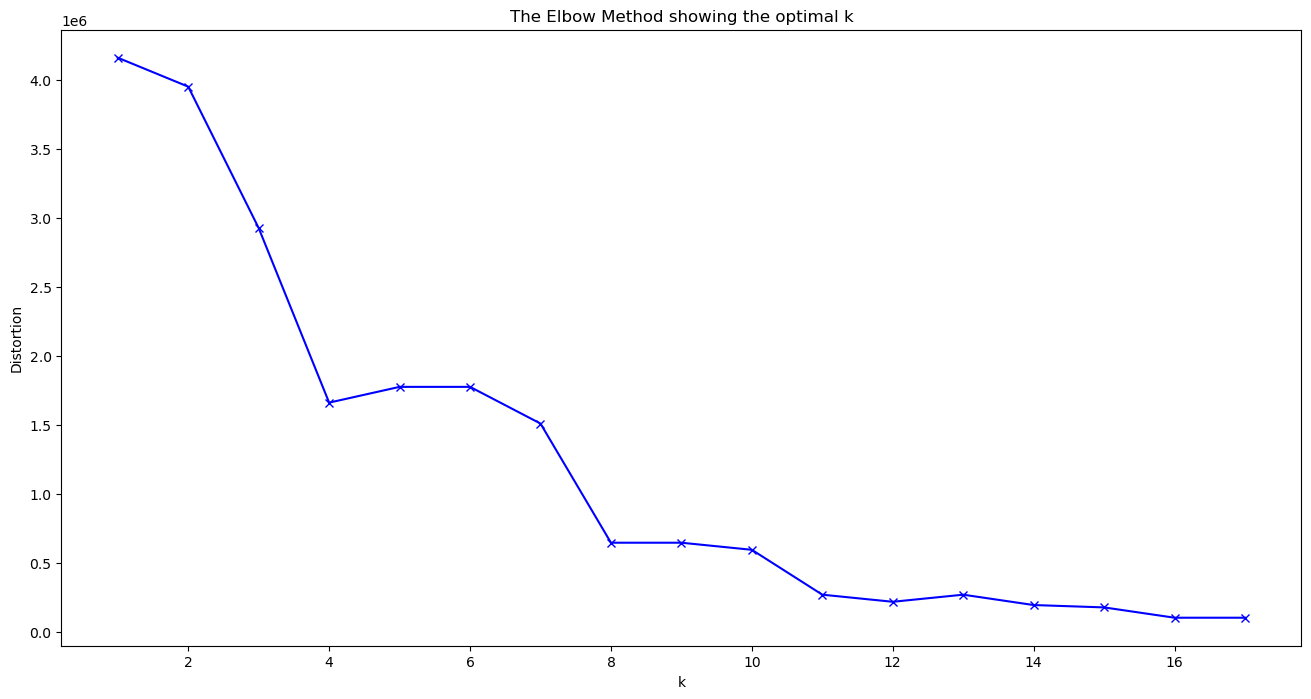

In [537]:
distortions = []
K = range(1, len(selected_stations.columns))
# tolerance and max_iterations are variables for K-Means -- this doesn't have to change

tolerance = 0.001
max_iterations = 100

for cluster in K:
    print('Broj klastera: ', cluster)
    kmeanModel = K_Means(cluster, tolerance, max_iterations)
    kmeanModel.fit(selected_stations)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [538]:
# select optimal number of clusters
# first we find the difference of the inertia values, the optimal number of clusters is on the 'elbow'
# we add 2 since the iteration of elements in the list starts from 0 and the differences are stored on the index before
optim_cluster = int(np.argmax(np.abs([j-i for i, j in zip(distortions[:-1], distortions[1:])]))) + 2
optim_cluster

4

In [539]:
selected_stations

,180433,180432,230087,180431,230084,173895,129443,230083,230082,230085,230086,154558,163591,154564,231041,140631,162001,162002
2024-07-01 00:00:00,0.001646,0.004558,-0.037369,-0.008502,49.903561,0.013441,0.011330,-0.023690,-0.006792,-0.014228,-0.038927,-0.006163,-0.006739,0.014212,0.001583,0.014557,0.015023,0.002342
2024-07-01 01:00:00,-0.001251,0.002591,-0.038153,-0.010221,49.926533,0.015207,0.004989,-0.017799,0.002367,-0.012709,-0.014096,0.022389,-0.027381,0.011083,-0.001536,0.013131,0.012481,0.005766
2024-07-01 02:00:00,-0.001178,-0.002357,-0.044554,-0.010646,50.061237,0.015112,-0.001001,-0.019416,0.017724,-0.012545,-0.019865,0.034257,-0.024249,0.007210,-0.002996,0.006496,0.009075,0.005912
2024-07-01 03:00:00,-0.001820,-0.002460,-0.043391,-0.009873,50.121849,0.011736,-0.001228,-0.020296,-0.087290,-0.013429,-0.027453,0.023682,-0.025979,0.005489,-0.003391,0.004777,0.003581,0.004845
2024-07-01 04:00:00,-0.001714,-0.002024,-0.044394,-0.009805,40.556461,0.013781,-0.001932,-0.020484,-0.043661,-0.013941,-0.023564,0.028297,-0.023684,0.004087,-0.003806,0.001849,0.004676,6.410806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30 20:00:00,0.002872,-0.002945,-0.026537,-0.001005,-0.008004,-0.004879,-0.003152,50.434105,33.847591,0.001324,50.099918,2.290171,9.058158,-0.000451,-0.011291,0.007878,0.001395,-0.008513
2024-08-30 21:00:00,0.003312,-0.002897,-0.024219,-0.000985,-0.007995,-0.007771,-0.003155,50.529125,50.347408,0.001454,49.990658,9.283546,30.288572,-0.003902,-0.002509,0.007482,0.001191,3.008567
2024-08-30 22:00:00,0.002950,-0.002812,-0.020635,-0.000964,-0.007985,-0.006281,-0.003153,12.675566,50.373814,0.001536,3.922932,2.631776,0.309092,-0.003286,-0.007437,0.006525,0.000996,2.744452
2024-08-30 23:00:00,0.002831,-0.002698,-0.019069,-0.000942,-0.007982,-0.004985,-0.003147,-0.025702,4.344916,0.001584,-0.002802,-0.025176,-0.017512,-0.000834,-0.002836,0.005218,0.000811,0.006307


In [540]:
# this is the print example
model = K_Means(optim_cluster, tolerance, max_iterations)
model.fit(selected_stations)

Cluster  1 , range  0.0 to 7.102579150638432
Cluster  2 , range  7.102579150638432 to 14.205158301276864
Cluster  3 , range  14.205158301276864 to 21.307737451915294
Cluster  4 , range  21.307737451915294 to 28.410316602553728
Not optimal.
Not optimal.
Not optimal.
Not optimal.


In [541]:
# this is also just print example
model.classifications

{0: [180433,
  180432,
  180431,
  173895,
  129443,
  154558,
  163591,
  154564,
  231041,
  140631,
  162001,
  162002],
 1: [230084, 230083, 230085, 230086],
 2: [230082],
 3: [230087]}

In [542]:
model.empty

[]

In [543]:
model.ranges

[7.102579150638432, 14.205158301276864, 21.307737451915294, 28.410316602553728]

In [544]:
# this is example of centroids -- those centroids that do not have stations in specific range have NaN values
model.centroids

{0: array([ 0.00477385,  0.00393734,  0.00296948, ...,  0.47265492,
        -0.00358031,  0.41574373]),
 1: array([ 1.24566787e+01,  1.24704821e+01,  1.25023528e+01, ...,
         4.14801219e+00, -8.72528553e-03, -1.00797117e-02]),
 2: array([-6.79230690e-03,  2.36737728e-03,  1.77237988e-02, ...,
         5.03738136e+01,  4.34491634e+00,  5.68389893e-03]),
 3: array([-0.03736866, -0.03815305, -0.04455447, ..., -0.02063477,
        -0.0190686 , -0.01113963])}

### User selection of buffer sizes 

In [545]:
def plot_stations(stations, geolocations, init_lat, init_long, list_empty, radius_buff):
    '''inputs: clusters of stations (in dictionary), geolocation (coordinates), initial coordinates of point, list of empty clusters'''

    colors = ['b','g','r','c','m','y', 'darkgreen', 'blueviolet', 'darkred', 'teal', 'plum']
    map = smopy.Map(init_lat-0.02, init_long-0.075, init_lat + 0.015, init_long + 0.025)
    
    x_coord = []
    y_coord = []
    labels =  []
    ax = map.show_mpl(figsize=(20, 12))
    x, y = map.to_pixels(init_lat, init_long)
    ax.plot(x, y, '*', ms = 12, color = 'k', label = 'Initial point')
    
    last_element = list(stations.keys())[-1]
        
    for key in stations.keys():
        color = colors[key]
        counter = 0
        for station in stations[key]:
            # print(stations[key])
            counter += 1
            geoloc_pom = geolocations.loc[geolocations['Location Id'] == station]
            #plt.scatter(geoloc_pom['Long'], geoloc_pom['Lat'], marker='o', s = 80, color = color, label = geoloc_pom['Location Friendly Name'].values[0])
            x, y = map.to_pixels(geoloc_pom['Lat'], geoloc_pom['Long'])
            ax.plot(x, y, 'o', color = color, ms=5, mew=2, label = 'Avg mean utilization up to {:.4f}'.format(float(model.ranges[key])) if counter == 1 else None)
            if key == last_element:
                # if the station is in the last cluster = it has the highest utilization --> create buffer
                circle1 = plt.Circle((x, y), 40, color='r', linestyle = 'dashed', fill = False)
                ax.add_patch(circle1)
                #ax.plot(x, y, ms=5, color='r', linestyle='dashed')
                print('Hi')
            if geoloc_pom['Location Friendly Name'].values[0].split(' ')[0] == 'Zagreb':
                name = geoloc_pom['Location Friendly Name'].values[0].split(' ', 1)[1]
            else:
                name = geoloc_pom['Location Friendly Name'].values[0]
            ax.text(x * (1 + 0.0), y * (1 - 0.01), name, fontsize=9)
        # if the cluster is empty:
        if key in list_empty:
            counter += 1
            ax.plot(np.NaN, np.NaN, 'o', color = color, ms=5, mew=2, label = 'Avg mean utilization up to {:.4f}'.format(float(model.ranges[key])) if counter == 1 else None)
    plt.legend()
    plt.title('Clusters = optimal, central point = Split, date = 15.07 - 15.08., r = 5km, buffer = 500 m')
    #plt.savefig(r'...\2 clusters, Split, r 5 km, summer, buffer.png')
    plt.show()
    
        

Cluster  1 , range  0.0 to 7.102579150638432
Cluster  2 , range  7.102579150638432 to 14.205158301276864
Cluster  3 , range  14.205158301276864 to 21.307737451915294
Cluster  4 , range  21.307737451915294 to 28.410316602553728
Not optimal.
Not optimal.
Not optimal.
Not optimal.
Lowered zoom level to keep map size reasonable. (z = 13)
Hi


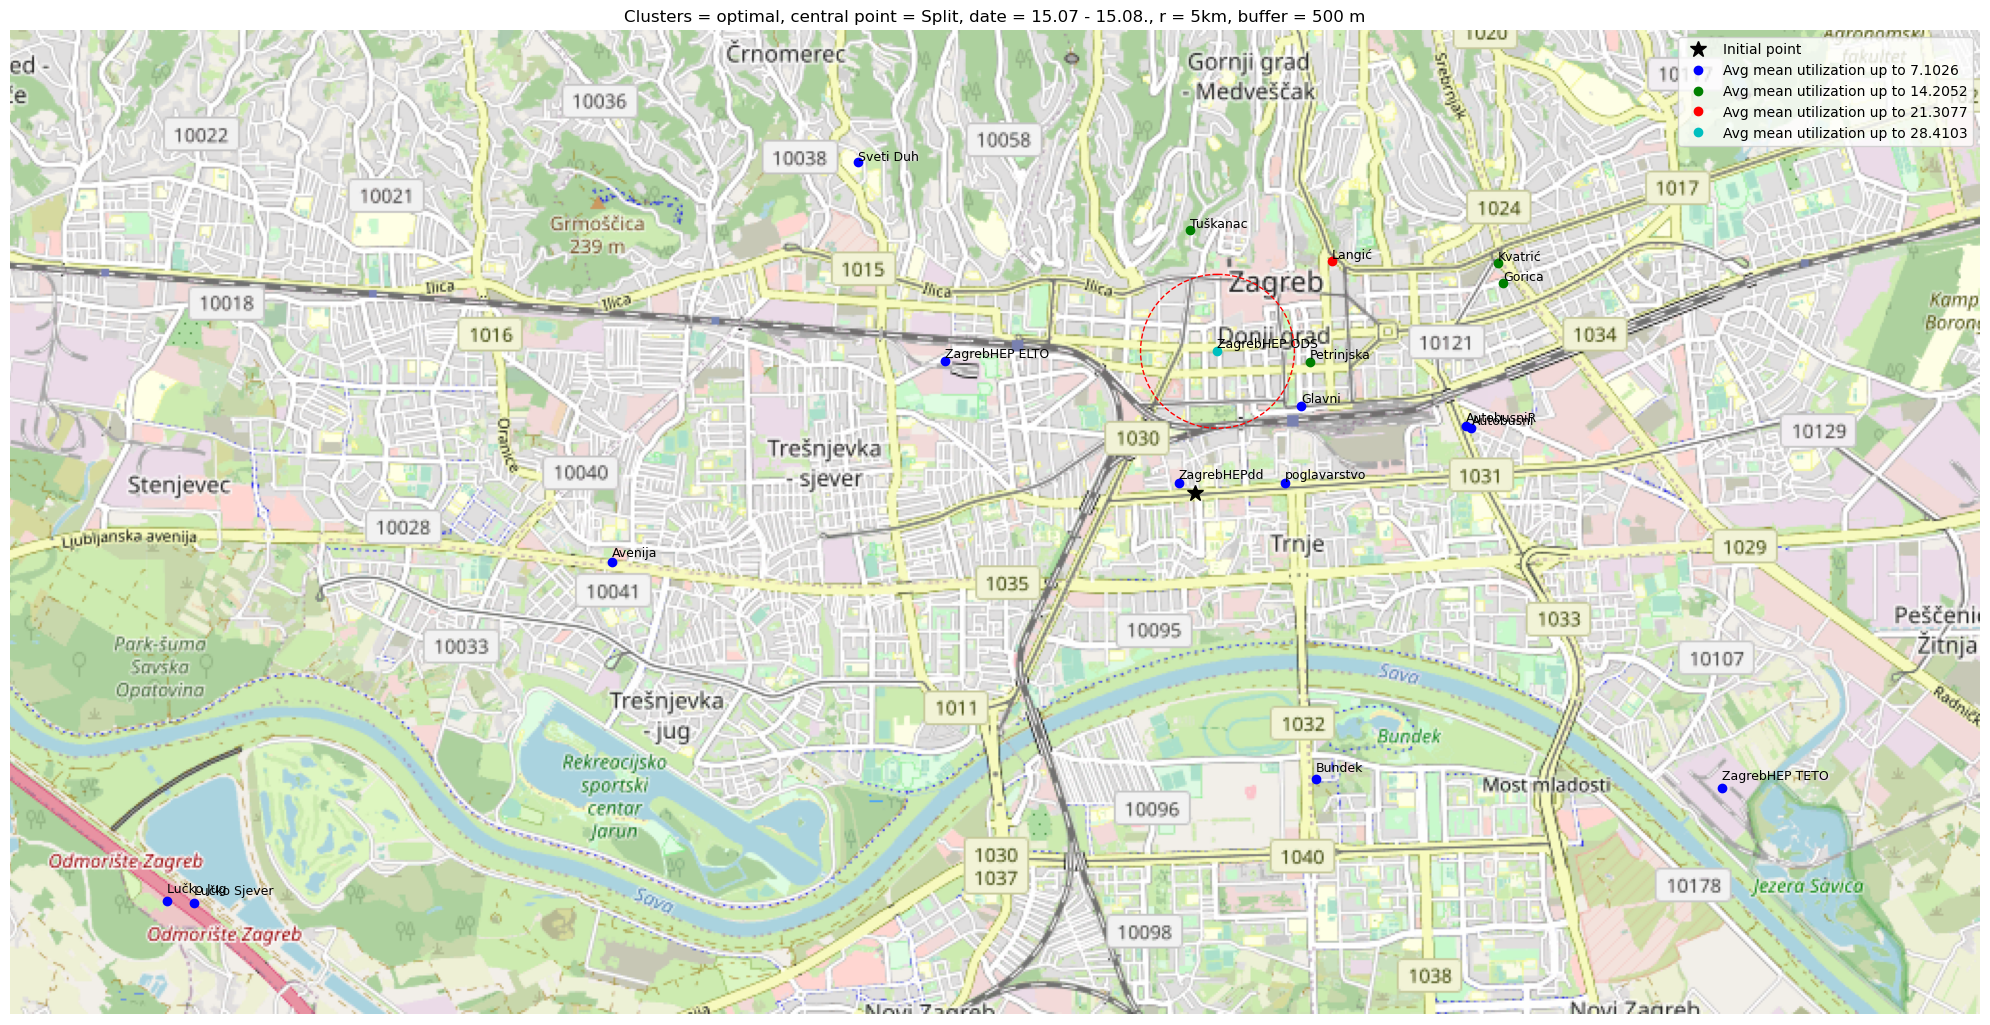

In [546]:
geoloc_pom = geolocation.reset_index()
model = K_Means(optim_cluster, tolerance, max_iterations)
model.fit(selected_stations)

plot_stations(model.classifications, geoloc_pom, lat_init, long_init, model.empty, radius_buffer)
